In [32]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import cv2, glob
import numpy as np
import time

import warnings
warnings.simplefilter('ignore')

start=time.time()
print("modules imported!>>>>>>>>>>>>>>>>>>>>>>")

#画像形式の指定
in_shape=(50, 50, 3)
nb_classes=2

#CNNモデル構造の定義
#入力層：50x50x3ch
#畳み込み層1: 3x3のカーネルを32個使う
#畳み込み層2: 3x3のカーネルを32個使う
#プーリング層1: 2x2で区切ってその中の最大値を使う
model=Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=in_shape))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#畳み込み層3: 3x3のカーネルを64個使う
#畳み込み層4: 3x3のカーネルを64個使う
#プーリング層1: 2x2で区切ってその中の最大値を使う
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#全結合層: 512
#出力層: 2(マスクありorなしの2値)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))


#モデルのコンパイル
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy']
)
print('model compiled!>>>>>>>>>>>>>>>>>>>>')

#画像データをNumpy形式に変換
x=[]
y=[]
def read_files(target_files, y_val):
    files=glob.glob(target_files)
    for fname in files:
        # print(fname)
        #画像の読み出し
        img=cv2.imread(fname)
        #画像サイズを50 x 50にリサイズ
        img=cv2.resize(img, (50,50))
        # print(img)
        x.append(img)
        y.append(np.array(y_val))

#ディレクトリ内の画像を集める
read_files("./image/mask_off/*.jpg", [1,0])
read_files("./image/mask_on/*.jpg", [0,1])
x_train, y_train=(np.array(x), np.array(y))
#
# """
# #学習用データの水増し
# """
# x_new=[]
# y_new=[]
# for i, xi in enumerate(x_train):
#     yi=y_train[i]
#     for ang in range(-30, 30, 5):
#         #回転
#         center=(25, 25)
#         mtx=cv2.getRotationMatrix2D(center, ang, 1.0)
#         xi2=cv2.warpAffine(xi, mtx, (50,50))
#         x_new.append(xi2)
#         y_new.append(yi)
#
#         #左右反転
#         xi3=cv2.flip(xi2,1)
#         x_new.append(xi3)
#         y_new.append(yi)
#
# #水増しした画像を学習用に置き換える
# print("水増し前：", len(y_train))
# x_train=np.array(x_new)
# y_train=np.array(y_new)
# print("水増し後：", len(y_train))

#テスト用画像をNumpy形式で得る
x,y=[[],[]]
read_files("./image/mask_off_test/*.jpg", [1,0])
read_files("./image/mask_on_test/*.jpg", [0,1])
x_test, y_test=(np.array(x), np.array(y))

#早期終了を加える
es_cb = EarlyStopping(patience = 10, restore_best_weights = True)

#データの学習
hist=model.fit(
    x_train,
    y_train,
    batch_size=100,
    epochs=100,
    validation_split=0.2,
    callbacks=[es_cb],
    validation_data=(x_test,y_test)
)
end=time.time()

#データの評価
score=model.evaluate(x_test, y_test, verbose=1)
print("正解率 = ",score[1], 'loss = ',score[0])
print("実行時間：", end-start)


modules imported!>>>>>>>>>>>>>>>>>>>>>>
model compiled!>>>>>>>>>>>>>>>>>>>>
Epoch 1/100
4/4 [==============================] - 5s 904ms/step - loss: 320.4228 - accuracy: 0.4899 - val_loss: 6.7208 - val_accuracy: 0.5618
Epoch 2/100
4/4 [==============================] - 3s 738ms/step - loss: 3.9810 - accuracy: 0.6910 - val_loss: 0.3815 - val_accuracy: 0.8539
Epoch 3/100
4/4 [==============================] - 3s 755ms/step - loss: 0.9253 - accuracy: 0.8191 - val_loss: 1.0319 - val_accuracy: 0.8764
Epoch 4/100
4/4 [==============================] - 3s 736ms/step - loss: 3.4230 - accuracy: 0.7211 - val_loss: 0.2740 - val_accuracy: 0.8876
Epoch 5/100
4/4 [==============================] - 3s 761ms/step - loss: 0.3596 - accuracy: 0.9045 - val_loss: 0.2564 - val_accuracy: 0.9213
Epoch 6/100
4/4 [==============================] - 3s 768ms/step - loss: 0.1776 - accuracy: 0.9548 - val_loss: 0.2855 - val_accuracy: 0.9551
Epoch 7/100
4/4 [==============================] - 3s 832ms/step - loss: 0.1

In [43]:
#混同行列
y_pred=model.predict(x_test)
y_pred
# print(confusion_matrix(y_pred, y_test))
# #間違って予測した画像をfaultdataフォルダに保存
# for i in range(len(y_test)):
#     filename=i+'.jpg'
#     if y_pred!=y_test:
#         plt.savefig('./image/fault_datas/'+filename)

3/3 [==============================] - 0s 95ms/step


array([[9.91919398e-01, 8.08057562e-03],
       [9.99925852e-01, 7.41553959e-05],
       [9.99581397e-01, 4.18652402e-04],
       [9.99926805e-01, 7.32096596e-05],
       [9.99887228e-01, 1.12727488e-04],
       [9.97939408e-01, 2.06052721e-03],
       [9.99555886e-01, 4.44060017e-04],
       [9.99599993e-01, 4.00081393e-04],
       [9.99990940e-01, 9.02012744e-06],
       [9.99188960e-01, 8.11015372e-04],
       [9.98725116e-01, 1.27487385e-03],
       [9.99428213e-01, 5.71724784e-04],
       [9.99551237e-01, 4.48687962e-04],
       [9.99707162e-01, 2.92850280e-04],
       [9.95470643e-01, 4.52942960e-03],
       [9.99272048e-01, 7.27969222e-04],
       [9.78739858e-01, 2.12601293e-02],
       [9.96568084e-01, 3.43189947e-03],
       [9.98938382e-01, 1.06167304e-03],
       [5.85345447e-01, 4.14654523e-01],
       [9.99999285e-01, 7.71427267e-07],
       [9.99870300e-01, 1.29626264e-04],
       [9.99999166e-01, 7.95440656e-07],
       [9.99990702e-01, 9.32205330e-06],
       [9.995747

89
89
[27]


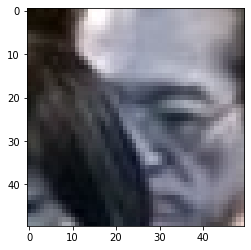

In [46]:
y_true=[]
y_predict=[]
fault_idx=[]

for i in range(len(y_pred)):
    filename=str(i)+".jpeg"
    y_predict.append(y_pred[i].argmax())
    y_true.append(y_test[i].argmax())
    if y_predict[i]!=y_true[i]:
        fault_idx.append(i)
    
print(len(y_true))
print(len(y_predict))
print(fault_idx)

for i in range(len(fault_idx)):
    plt.imshow(x_test[i])
    
plt.show()

In [47]:
confusion_matrix(y_predict,y_true)

array([[49,  0],
       [ 1, 39]])

In [49]:
y_test[27]

array([1, 0])

In [39]:
#混同行列
y_pred=model.predict(x_train)

y_true=[]
y_predict=[]

for i in range(len(y_pred)):
    y_predict.append(y_pred[i].argmax())
    y_true.append(y_train[i].argmax())
    if y_predict[i]!=y_true[i]:
        print(i)
    
print(len(y_true))
print(len(y_predict))

13/13 [==============================] - 1s 62ms/step
398
398


In [40]:
confusion_matrix(y_predict,y_true)

array([[250,   0],
       [  0, 148]])

In [10]:
import numpy as np
import IPython

rate = 48000
duration = 1.0
t = np.linspace(0., duration, int(rate*duration))
x = np.sin(2.0*np.pi*440.0*t)
IPython.display.Audio(x, rate=rate, autoplay=True)

In [19]:
#coding:utf-8
import pygame.mixer
import time

def sound(f,i,n):
    pygame.mixer.init() #初期化します
    pygame.mixer.music.load(f) #音声ファイルを読み込みます
    pygame.mixer.music.play(i) #再生します
    time.sleep(n) #再生時間を指定します
    pygame.mixer.music.stop() #終了します

sound("Warning-Siren05-02(Fast-Long).mp3",2,5)